<h3>导入包</h3>

In [38]:
import os
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMRegressor
import numpy as np
from datetime import datetime
from chinese_calendar import is_workday
import seaborn as sns
import warnings
import zipfile
from zipfile import ZipFile


warnings.filterwarnings('ignore')

<h3>读入数据</h3>

In [39]:
sub_sheet_name = ["二层插座", "二层照明", "一层插座", "一层照明", "空调"]
data_dict = {}
for name in sub_sheet_name:
    data_dict[name] = pd.read_csv('../data/Data_A/' + name + '_EC.csv')
    data_dict[name]["time"] = pd.to_datetime(data_dict[name]["time"])
data_dict

{'二层插座':                      time     value
 0     2013-08-03 00:00:00  0.164062
 1     2013-08-03 00:15:00  0.121094
 2     2013-08-03 00:30:00  0.101562
 3     2013-08-03 00:45:00  0.087891
 4     2013-08-03 01:00:00  0.103516
 ...                   ...       ...
 63395 2015-08-03 22:45:00  0.082031
 63396 2015-08-03 23:00:00  0.128906
 63397 2015-08-03 23:15:00  0.125000
 63398 2015-08-03 23:30:00  0.082031
 63399 2015-08-03 23:45:00  0.160156
 
 [63400 rows x 2 columns],
 '二层照明':                      time     value
 0     2013-08-03 00:00:00  0.500000
 1     2013-08-03 00:15:00  0.507812
 2     2013-08-03 00:30:00  0.476562
 3     2013-08-03 00:45:00  0.117188
 4     2013-08-03 01:00:00  0.000000
 ...                   ...       ...
 63643 2015-08-03 22:45:00  0.000000
 63644 2015-08-03 23:00:00  0.000000
 63645 2015-08-03 23:15:00  0.000000
 63646 2015-08-03 23:30:00  0.000000
 63647 2015-08-03 23:45:00  0.000000
 
 [63648 rows x 2 columns],
 '一层插座':                      time    

<h3>读入天气数据</h3>

In [40]:
wh = pd.read_csv("../data/Data_A/天气.csv")
wh["日期"] = pd.to_datetime(wh["日期"])
wh["time"] = wh["日期"] + pd.to_timedelta(wh["小时"], "h")
wh.drop(["Unnamed: 0", "日期", "小时"], axis=1, inplace=True)
wh

,温度(C°),湿度(%),降雨量(mm),大气压(hPa),风向,风向角度(°),风速(KM/H),云量(%),time
0,28,88,1.0,1006,东南风,159,9,71,2013-08-03 00:00:00
1,28,88,0.9,1006,东南风,155,8,75,2013-08-03 01:00:00
2,28,89,0.7,1006,东南风,150,8,54,2013-08-03 02:00:00
3,27,90,0.5,1006,东南风,151,8,25,2013-08-03 03:00:00
4,27,90,0.2,1006,东南风,151,8,35,2013-08-03 04:00:00
...,...,...,...,...,...,...,...,...,...
18043,27,67,0.0,1006,东北风,43,11,1,2015-08-24 19:00:00
18044,26,72,0.0,1007,东北风,45,9,0,2015-08-24 20:00:00
18045,25,75,0.4,1007,东北风,35,7,2,2015-08-24 21:00:00
18046,24,78,0.7,1007,东北风,25,6,1,2015-08-24 22:00:00


<h3>处理缺失数据</h3>
<ul>
<li>由于大赛提供的数据表存在不同程度的数据缺失问题，将数据对其、合并，并将缺失数据删除。</li>
<li>由于大赛提供的数据表存在不同程度的数据缺失问题，将数据对其、合并，并将缺失数据删除。</li>
</ul>

In [41]:
data = pd.merge(data_dict["二层插座"],data_dict["二层照明"],on='time', how="inner", suffixes=("_socket_2","_light_2"))
data = pd.merge(data,data_dict["一层插座"],on='time', how="inner", suffixes=("","_socket_1"))
data = pd.merge(data,data_dict["一层照明"],on='time', how="inner", suffixes=("","_light_1"))
data = pd.merge(data,data_dict["空调"],on='time', how="inner", suffixes=("","_air"))
data = data.rename(columns={"value":"value_socket_1"})
data

,time,value_socket_2,value_light_2,value_socket_1,value_light_1,value_air
0,2013-08-03 00:00:00,0.164062,0.500000,0.113281,0.542969,4.234375
1,2013-08-03 00:15:00,0.121094,0.507812,0.273438,0.542969,5.093750
2,2013-08-03 00:30:00,0.101562,0.476562,0.277344,0.515625,3.234375
3,2013-08-03 00:45:00,0.087891,0.117188,0.218750,0.437500,3.187500
4,2013-08-03 01:00:00,0.103516,0.000000,0.082031,0.406250,3.171875
...,...,...,...,...,...,...
63160,2015-08-03 22:45:00,0.082031,0.000000,0.097656,0.250000,2.250000
63161,2015-08-03 23:00:00,0.128906,0.000000,0.175781,0.242188,2.343750
63162,2015-08-03 23:15:00,0.125000,0.000000,0.101562,0.226562,2.093750
63163,2015-08-03 23:30:00,0.082031,0.000000,0.164062,0.171875,2.312500


<h3>将一层、二层插座能耗相加，一层、二层照明能耗相加构造数据：</h3>

In [42]:
data["value_socket"] = data["value_socket_2"] + data["value_socket_1"]
data["value_light"] = data["value_light_2"] + data["value_light_1"]
data.drop(['value_socket_2','value_light_2','value_socket_1','value_light_1'], axis=1, inplace=True)
data

,time,value_air,value_socket,value_light
0,2013-08-03 00:00:00,4.234375,0.277344,1.042969
1,2013-08-03 00:15:00,5.093750,0.394531,1.050781
2,2013-08-03 00:30:00,3.234375,0.378906,0.992188
3,2013-08-03 00:45:00,3.187500,0.306641,0.554688
4,2013-08-03 01:00:00,3.171875,0.185547,0.406250
...,...,...,...,...
63160,2015-08-03 22:45:00,2.250000,0.179688,0.250000
63161,2015-08-03 23:00:00,2.343750,0.304688,0.242188
63162,2015-08-03 23:15:00,2.093750,0.226562,0.226562
63163,2015-08-03 23:30:00,2.312500,0.246094,0.171875


<h3>将数据尺度调整为每小时，并根据赛题要求选定数据范围，构造特征：</h3>

In [43]:
data["workday"] = data["time"].apply(lambda x: is_workday(x))
data['hour'] = data['time'].dt.hour
data['week'] = data['time'].dt.weekday
data['day'] = data['time'].dt.day
data['month'] = data['time'].dt.month
data['year'] = data['time'].dt.year
data = data.groupby(["year",'month','day','week','hour','workday'])[['value_socket','value_light','value_air']].sum().reset_index()
data

,year,month,day,week,hour,workday,value_socket,value_light,value_air
0,2013,8,3,5,0,False,1.357422,3.640625,15.750000
1,2013,8,3,5,1,False,0.785156,1.621094,12.390625
2,2013,8,3,5,2,False,0.771484,1.632812,10.953125
3,2013,8,3,5,3,False,0.830078,1.613281,11.343750
4,2013,8,3,5,4,False,1.162109,1.812500,12.671875
...,...,...,...,...,...,...,...,...,...
15887,2015,8,3,0,19,True,1.367188,2.851562,22.593750
15888,2015,8,3,0,20,True,1.402344,1.687500,19.281250
15889,2015,8,3,0,21,True,1.273438,1.609375,16.312500
15890,2015,8,3,0,22,True,1.035156,1.046875,9.062500


<h3>同样处理天气数据，并进行merge：</h3>

In [44]:
wh['hour'] = wh['time'].dt.hour
wh['week'] = wh['time'].dt.weekday
wh['day'] = wh['time'].dt.day
wh['month'] = wh['time'].dt.month
wh['year'] = wh['time'].dt.year
data = pd.merge(data,wh,on=['hour','week','day','month','year'], how="inner")
data = data.rename(columns={
    "温度(C°)":"temp",
    "湿度(%)":"humidity",
    "降雨量(mm)":"rainfall",
    "大气压(hPa)":"atmos",
    "风向":"wind_direction",
    "风向角度(°)":"wind_angle",
    "风速(KM/H)":"wind_speed",
    "云量(%)":"cloud"
})
data

,year,month,day,week,hour,workday,value_socket,value_light,value_air,temp,humidity,rainfall,atmos,wind_direction,wind_angle,wind_speed,cloud,time
0,2013,8,3,5,0,False,1.357422,3.640625,15.750000,28,88,1.0,1006,东南风,159,9,71,2013-08-03 00:00:00
1,2013,8,3,5,1,False,0.785156,1.621094,12.390625,28,88,0.9,1006,东南风,155,8,75,2013-08-03 01:00:00
2,2013,8,3,5,2,False,0.771484,1.632812,10.953125,28,89,0.7,1006,东南风,150,8,54,2013-08-03 02:00:00
3,2013,8,3,5,3,False,0.830078,1.613281,11.343750,27,90,0.5,1006,东南风,151,8,25,2013-08-03 03:00:00
4,2013,8,3,5,4,False,1.162109,1.812500,12.671875,27,90,0.2,1006,东南风,151,8,35,2013-08-03 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15887,2015,8,3,0,19,True,1.367188,2.851562,22.593750,36,55,0.0,1000,南风,190,23,100,2015-08-03 19:00:00
15888,2015,8,3,0,20,True,1.402344,1.687500,19.281250,35,57,0.0,1001,南风,189,22,100,2015-08-03 20:00:00
15889,2015,8,3,0,21,True,1.273438,1.609375,16.312500,33,57,0.0,1001,西南风,197,23,100,2015-08-03 21:00:00
15890,2015,8,3,0,22,True,1.035156,1.046875,9.062500,32,57,0.0,1002,西南风,206,23,98,2015-08-03 22:00:00


In [45]:
le_wind = LabelEncoder()
data['wind_direction'] = le_wind.fit_transform(data['wind_direction'])
data['wind_direction'] = data['wind_direction'].astype('category')

le_workday = LabelEncoder()
data['workday'] = le_workday.fit_transform(data['workday'])
data['workday'] = data['workday'].astype('category')
data

,year,month,day,week,hour,workday,value_socket,value_light,value_air,temp,humidity,rainfall,atmos,wind_direction,wind_angle,wind_speed,cloud,time
0,2013,8,3,5,0,0,1.357422,3.640625,15.750000,28,88,1.0,1006,1,159,9,71,2013-08-03 00:00:00
1,2013,8,3,5,1,0,0.785156,1.621094,12.390625,28,88,0.9,1006,1,155,8,75,2013-08-03 01:00:00
2,2013,8,3,5,2,0,0.771484,1.632812,10.953125,28,89,0.7,1006,1,150,8,54,2013-08-03 02:00:00
3,2013,8,3,5,3,0,0.830078,1.613281,11.343750,27,90,0.5,1006,1,151,8,25,2013-08-03 03:00:00
4,2013,8,3,5,4,0,1.162109,1.812500,12.671875,27,90,0.2,1006,1,151,8,35,2013-08-03 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15887,2015,8,3,0,19,1,1.367188,2.851562,22.593750,36,55,0.0,1000,4,190,23,100,2015-08-03 19:00:00
15888,2015,8,3,0,20,1,1.402344,1.687500,19.281250,35,57,0.0,1001,4,189,22,100,2015-08-03 20:00:00
15889,2015,8,3,0,21,1,1.273438,1.609375,16.312500,33,57,0.0,1001,6,197,23,100,2015-08-03 21:00:00
15890,2015,8,3,0,22,1,1.035156,1.046875,9.062500,32,57,0.0,1002,6,206,23,98,2015-08-03 22:00:00


<h3>绘制曲线：</h3>

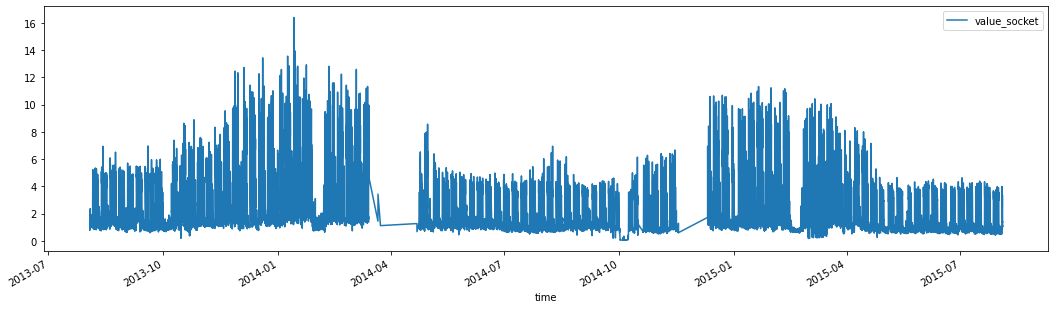

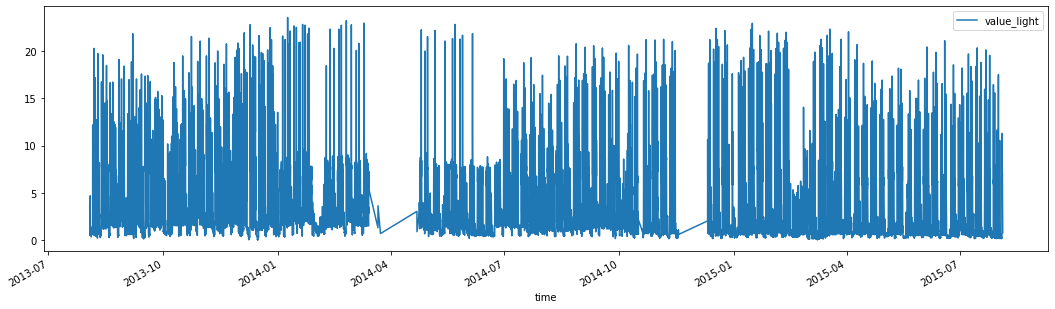

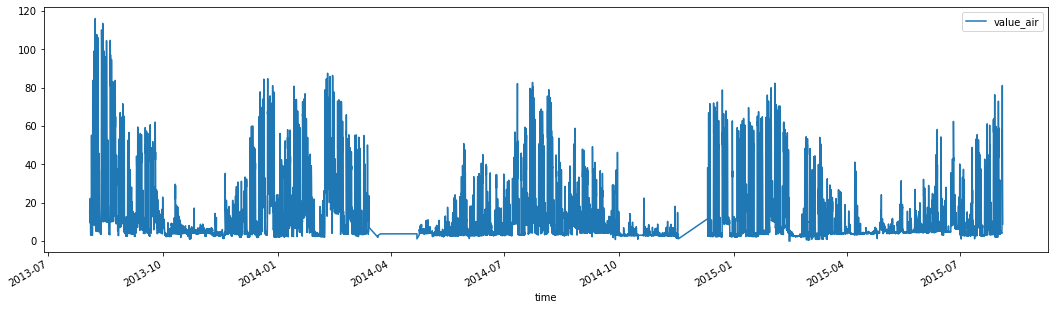

In [46]:
data.plot("time","value_socket",figsize=(18,5))
data.plot("time","value_light",figsize=(18,5))
data.plot("time","value_air",figsize=(18,5))
data.drop('time', axis=1, inplace=True)

<h3>多步直接预测</h3>
<ul>
<li>这里采用多步直接预测来构建数据；</li>
</ul>

In [47]:
data_socket = data.copy()
for i in range(7*24):
    data_socket['value_socket_{}'.format(i)] = data_socket['value_socket'].shift(-i-1)
data_socket.dropna(inplace=True)
data_socket

,year,month,day,week,hour,workday,value_socket,value_light,value_air,temp,...,value_socket_158,value_socket_159,value_socket_160,value_socket_161,value_socket_162,value_socket_163,value_socket_164,value_socket_165,value_socket_166,value_socket_167
0,2013,8,3,5,0,0,1.357422,3.640625,15.750000,28,...,2.591797,2.384766,1.912109,1.457031,1.484375,1.671875,1.595703,1.271484,0.986328,1.339844
1,2013,8,3,5,1,0,0.785156,1.621094,12.390625,28,...,2.384766,1.912109,1.457031,1.484375,1.671875,1.595703,1.271484,0.986328,1.339844,0.894531
2,2013,8,3,5,2,0,0.771484,1.632812,10.953125,28,...,1.912109,1.457031,1.484375,1.671875,1.595703,1.271484,0.986328,1.339844,0.894531,0.923828
3,2013,8,3,5,3,0,0.830078,1.613281,11.343750,27,...,1.457031,1.484375,1.671875,1.595703,1.271484,0.986328,1.339844,0.894531,0.923828,1.753906
4,2013,8,3,5,4,0,1.162109,1.812500,12.671875,27,...,1.484375,1.671875,1.595703,1.271484,0.986328,1.339844,0.894531,0.923828,1.753906,1.794922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15719,2015,7,27,0,18,1,2.238281,6.000000,34.656250,35,...,3.914062,3.519531,3.136719,2.894531,2.488281,3.328125,3.355469,3.046875,1.675781,1.367188
15720,2015,7,27,0,19,1,1.562500,4.117188,12.187500,34,...,3.519531,3.136719,2.894531,2.488281,3.328125,3.355469,3.046875,1.675781,1.367188,1.402344
15721,2015,7,27,0,20,1,1.371094,2.203125,4.562500,33,...,3.136719,2.894531,2.488281,3.328125,3.355469,3.046875,1.675781,1.367188,1.402344,1.273438
15722,2015,7,27,0,21,1,1.070312,1.554688,3.812500,32,...,2.894531,2.488281,3.328125,3.355469,3.046875,1.675781,1.367188,1.402344,1.273438,1.035156


<h3>划分训练集、验证数据集：</h3>

In [48]:
targets = [item for item in data_socket.columns if 'value_socket_' in item]

X_train_socket = data_socket.drop(targets, axis=1)[: int(len(data_socket) * 0.95)]
y_train_socket = data_socket[targets][: int(len(data_socket) * 0.95)]

X_test_socket = data_socket.drop(targets, axis=1)[int(len(data_socket) * 0.95) :]
y_test_socket = data_socket[targets][int(len(data_socket) * 0.95) :]

X_train_socket

,year,month,day,week,hour,workday,value_socket,value_light,value_air,temp,humidity,rainfall,atmos,wind_direction,wind_angle,wind_speed,cloud
0,2013,8,3,5,0,0,1.357422,3.640625,15.750000,28,88,1.0,1006,1,159,9,71
1,2013,8,3,5,1,0,0.785156,1.621094,12.390625,28,88,0.9,1006,1,155,8,75
2,2013,8,3,5,2,0,0.771484,1.632812,10.953125,28,89,0.7,1006,1,150,8,54
3,2013,8,3,5,3,0,0.830078,1.613281,11.343750,27,90,0.5,1006,1,151,8,25
4,2013,8,3,5,4,0,1.162109,1.812500,12.671875,27,90,0.2,1006,1,151,8,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14932,2015,6,24,2,23,1,0.910156,0.796875,8.750000,22,92,0.2,1003,2,87,21,100
14933,2015,6,25,3,0,1,0.851562,1.093750,12.125000,21,92,0.6,1003,2,88,19,100
14934,2015,6,25,3,1,1,0.675781,0.460938,8.687500,21,93,1.0,1002,2,90,18,100
14935,2015,6,25,3,2,1,0.578125,0.500000,8.812500,20,93,1.4,1002,2,91,17,100


In [49]:
y_train_socket

,value_socket_0,value_socket_1,value_socket_2,value_socket_3,value_socket_4,value_socket_5,value_socket_6,value_socket_7,value_socket_8,value_socket_9,...,value_socket_158,value_socket_159,value_socket_160,value_socket_161,value_socket_162,value_socket_163,value_socket_164,value_socket_165,value_socket_166,value_socket_167
0,0.785156,0.771484,0.830078,1.162109,1.144531,1.179688,1.478516,1.218750,1.525391,1.589844,...,2.591797,2.384766,1.912109,1.457031,1.484375,1.671875,1.595703,1.271484,0.986328,1.339844
1,0.771484,0.830078,1.162109,1.144531,1.179688,1.478516,1.218750,1.525391,1.589844,2.359375,...,2.384766,1.912109,1.457031,1.484375,1.671875,1.595703,1.271484,0.986328,1.339844,0.894531
2,0.830078,1.162109,1.144531,1.179688,1.478516,1.218750,1.525391,1.589844,2.359375,1.449219,...,1.912109,1.457031,1.484375,1.671875,1.595703,1.271484,0.986328,1.339844,0.894531,0.923828
3,1.162109,1.144531,1.179688,1.478516,1.218750,1.525391,1.589844,2.359375,1.449219,1.496094,...,1.457031,1.484375,1.671875,1.595703,1.271484,0.986328,1.339844,0.894531,0.923828,1.753906
4,1.144531,1.179688,1.478516,1.218750,1.525391,1.589844,2.359375,1.449219,1.496094,1.976562,...,1.484375,1.671875,1.595703,1.271484,0.986328,1.339844,0.894531,0.923828,1.753906,1.794922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14932,0.851562,0.675781,0.578125,0.605469,0.601562,0.867188,1.222656,1.171875,1.214844,3.796875,...,2.558594,2.929688,3.320312,2.933594,1.640625,1.226562,0.988281,1.117188,0.890625,1.066406
14933,0.675781,0.578125,0.605469,0.601562,0.867188,1.222656,1.171875,1.214844,3.796875,3.425781,...,2.929688,3.320312,2.933594,1.640625,1.226562,0.988281,1.117188,0.890625,1.066406,0.964844
14934,0.578125,0.605469,0.601562,0.867188,1.222656,1.171875,1.214844,3.796875,3.425781,3.660156,...,3.320312,2.933594,1.640625,1.226562,0.988281,1.117188,0.890625,1.066406,0.964844,0.835938
14935,0.605469,0.601562,0.867188,1.222656,1.171875,1.214844,3.796875,3.425781,3.660156,3.332031,...,2.933594,1.640625,1.226562,0.988281,1.117188,0.890625,1.066406,0.964844,0.835938,0.921875


<h3>自回归模型构建</h3>
<ul>
<li>这里我们使用Auto-regressive distributed lags来构建模型，并使用LightGBM进行预测；</li>
</ul>

In [50]:
model_socket = MultiOutputRegressor(lgb.LGBMRegressor(objective='regression')).fit(X_train_socket, y_train_socket)

<h3>使用划分出的测试集测试：</h3>

In [51]:
pred_socket = pd.DataFrame(model_socket.predict(X_test_socket), columns=targets)
pred_socket.index = y_test_socket.index
pred_socket

,value_socket_0,value_socket_1,value_socket_2,value_socket_3,value_socket_4,value_socket_5,value_socket_6,value_socket_7,value_socket_8,value_socket_9,...,value_socket_158,value_socket_159,value_socket_160,value_socket_161,value_socket_162,value_socket_163,value_socket_164,value_socket_165,value_socket_166,value_socket_167
14937,0.870019,1.079075,1.192771,1.251239,3.719293,3.155055,3.383754,3.402171,3.158717,3.330752,...,1.472091,1.343064,1.216699,1.179887,1.195768,0.908289,0.822089,0.808710,0.726027,0.826974
14938,1.067245,1.170999,1.308517,3.510635,3.217464,3.246552,3.324659,3.046928,3.009071,3.308587,...,1.382848,1.343064,1.228658,1.209895,1.028735,0.857727,0.823240,0.806483,0.798481,0.959474
14939,1.495142,1.678222,3.960564,3.522638,3.443330,3.297141,3.162459,3.249445,3.000363,3.278321,...,1.368589,1.382956,1.349216,1.046148,0.884738,0.850456,0.845495,0.896926,0.954935,1.261319
14940,1.383810,3.456711,3.433520,3.587232,3.359264,2.989370,3.111543,3.161307,3.217543,2.925721,...,1.384407,1.406791,1.128520,0.905785,0.899921,0.897163,0.916609,0.960421,1.062234,1.286230
14941,3.687908,3.425106,3.619876,3.640564,3.004035,3.037880,3.158660,3.295299,2.832485,1.961394,...,1.411921,1.091327,0.906280,0.905785,0.889214,0.939484,1.008697,1.056010,1.086898,1.361843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15719,1.764330,1.406801,1.281188,1.270086,1.287682,1.095278,0.958033,0.895551,0.829706,0.795742,...,3.551613,3.580816,3.702274,3.532609,3.465208,3.493985,3.484213,3.360412,2.864577,2.066726
15720,1.308862,1.268358,1.160630,1.161192,1.017001,0.951086,0.843482,0.868441,0.863494,0.952039,...,3.368446,3.618178,3.389810,3.359679,3.244966,3.386174,3.237934,2.836712,1.942780,1.569960
15721,1.297691,1.226673,1.278470,1.048602,0.856081,0.935533,0.903661,0.924702,1.067331,1.306283,...,3.514220,3.555076,3.401275,3.440262,3.275831,3.450986,2.873894,1.912658,1.631381,1.288927
15722,1.105616,1.256130,0.859047,0.757971,0.765438,0.780176,0.726958,0.912238,1.144263,1.210195,...,3.518641,3.500302,3.333303,3.520516,3.159533,2.707914,2.014105,1.370282,1.303755,1.167827


In [52]:
y_test_socket

,value_socket_0,value_socket_1,value_socket_2,value_socket_3,value_socket_4,value_socket_5,value_socket_6,value_socket_7,value_socket_8,value_socket_9,...,value_socket_158,value_socket_159,value_socket_160,value_socket_161,value_socket_162,value_socket_163,value_socket_164,value_socket_165,value_socket_166,value_socket_167
14937,0.867188,1.222656,1.171875,1.214844,3.796875,3.425781,3.660156,3.332031,3.480469,3.585938,...,1.226562,0.988281,1.117188,0.890625,1.066406,0.964844,0.835938,0.921875,0.664062,1.238281
14938,1.222656,1.171875,1.214844,3.796875,3.425781,3.660156,3.332031,3.480469,3.585938,3.171875,...,0.988281,1.117188,0.890625,1.066406,0.964844,0.835938,0.921875,0.664062,1.238281,1.285156
14939,1.171875,1.214844,3.796875,3.425781,3.660156,3.332031,3.480469,3.585938,3.171875,3.019531,...,1.117188,0.890625,1.066406,0.964844,0.835938,0.921875,0.664062,1.238281,1.285156,1.242188
14940,1.214844,3.796875,3.425781,3.660156,3.332031,3.480469,3.585938,3.171875,3.019531,2.503906,...,0.890625,1.066406,0.964844,0.835938,0.921875,0.664062,1.238281,1.285156,1.242188,1.464844
14941,3.796875,3.425781,3.660156,3.332031,3.480469,3.585938,3.171875,3.019531,2.503906,2.019531,...,1.066406,0.964844,0.835938,0.921875,0.664062,1.238281,1.285156,1.242188,1.464844,1.359375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15719,1.562500,1.371094,1.070312,1.027344,1.101562,0.929688,0.585938,0.617188,0.492188,0.527344,...,3.914062,3.519531,3.136719,2.894531,2.488281,3.328125,3.355469,3.046875,1.675781,1.367188
15720,1.371094,1.070312,1.027344,1.101562,0.929688,0.585938,0.617188,0.492188,0.527344,0.894531,...,3.519531,3.136719,2.894531,2.488281,3.328125,3.355469,3.046875,1.675781,1.367188,1.402344
15721,1.070312,1.027344,1.101562,0.929688,0.585938,0.617188,0.492188,0.527344,0.894531,1.195312,...,3.136719,2.894531,2.488281,3.328125,3.355469,3.046875,1.675781,1.367188,1.402344,1.273438
15722,1.027344,1.101562,0.929688,0.585938,0.617188,0.492188,0.527344,0.894531,1.195312,1.242188,...,2.894531,2.488281,3.328125,3.355469,3.046875,1.675781,1.367188,1.402344,1.273438,1.035156


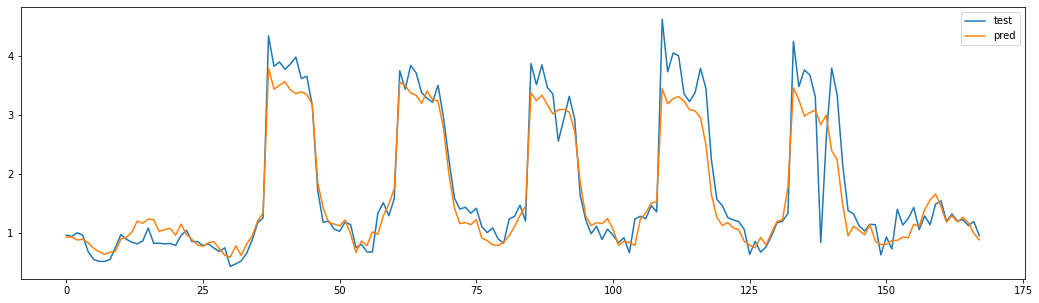

In [53]:
pred_num_socket = pred_socket.loc[15000,:].tolist()
y_test_num_socket = y_test_socket.loc[15000,:].tolist()
plt.figure(figsize=(18,5))
plt.plot(y_test_num_socket, label="test")
plt.plot(pred_num_socket, label="pred")
plt.legend()

<h3>分别计算七天的R2，并按照大赛评分标准计算R2_T_socket：</h3>

In [54]:
R2_list_socket = []
weight_socket = [0.25, 0.15, 0.15, 0.15, 0.1, 0.1, 0.1]
for day in range(7):
    day_list = []
    for i in range(day*24,(day+1)*24):
        day_list.append('value_socket_{}'.format(i))
    pred_day_socket = pred_socket[day_list]
    test_day_socket = y_test_socket[day_list]
    R2_list_socket.append(r2_score(test_day_socket, pred_day_socket))
R2_T_socket = np.multiply(np.array(weight_socket), np.array(R2_list_socket)).sum()
R2_T_socket

0.889698522991768

<h3>同样的方法预测照明能耗，并计算R2_T_light：</h3>

In [55]:
data_light = data.copy()
for i in range(7*24):
    data_light['value_light_{}'.format(i)] = data_light['value_light'].shift(-i-1)
data_light.dropna(inplace=True)

targets = [item for item in data_light.columns if 'value_light_' in item]

X_train_light = data_light.drop(targets, axis=1)[: int(len(data_light) * 0.95)]
y_train_light = data_light[targets][: int(len(data_light) * 0.95)]

X_test_light = data_light.drop(targets, axis=1)[int(len(data_light) * 0.95) :]
y_test_light = data_light[targets][int(len(data_light) * 0.95) :]

model_light = MultiOutputRegressor(lgb.LGBMRegressor(objective='regression')).fit(X_train_light, y_train_light)

pred_light = pd.DataFrame(model_light.predict(X_test_light), columns=targets)
pred_light.index = y_test_light.index

R2_list_light = []
weight_light = [0.25, 0.15, 0.15, 0.15, 0.1, 0.1, 0.1]
for day in range(7):
    day_list = []
    for i in range(day*24,(day+1)*24):
        day_list.append('value_light_{}'.format(i))
    pred_day_light = pred_light[day_list]
    test_day_light = y_test_light[day_list]
    R2_list_light.append(r2_score(test_day_light, pred_day_light))
R2_T_light = np.multiply(np.array(weight_light), np.array(R2_list_light)).sum()
R2_T_light

0.816267233289153

<h3>同样的方法预测空调能耗，并计算R2_T_air：</h3>

In [56]:
data_air = data.copy()
for i in range(7*24):
    data_air['value_air_{}'.format(i)] = data_air['value_air'].shift(-i-1)
data_air.dropna(inplace=True)

targets = [item for item in data_air.columns if 'value_air_' in item]

X_train_air = data_air.drop(targets, axis=1)[: int(len(data_air) * 0.95)]
y_train_air = data_air[targets][: int(len(data_air) * 0.95)]

X_test_air = data_air.drop(targets, axis=1)[int(len(data_air) * 0.95) :]
y_test_air = data_air[targets][int(len(data_air) * 0.95) :]

model_air = MultiOutputRegressor(lgb.LGBMRegressor(objective='regression')).fit(X_train_air, y_train_air)

pred_air = pd.DataFrame(model_air.predict(X_test_air), columns=targets)
pred_air.index = y_test_air.index

R2_list_air = []
weight_air = [0.25, 0.15, 0.15, 0.15, 0.1, 0.1, 0.1]
for day in range(7):
    day_list = []
    for i in range(day*24,(day+1)*24):
        day_list.append('value_air_{}'.format(i))
    pred_day_air = pred_air[day_list]
    test_day_air = y_test_air[day_list]
    R2_list_air.append(r2_score(test_day_air, pred_day_air))
R2_T_air = np.multiply(np.array(weight_air), np.array(R2_list_air)).sum()
R2_T_air

0.5850695602226172

<h3>计算总能耗，并计算R2_T_total：</h3>

In [57]:
for i in range(7*24):
    y_test_air = y_test_air.rename(columns={"value_air_{}".format(i):"value_total_{}".format(i)})
    y_test_light = y_test_light.rename(columns={"value_light_{}".format(i):"value_total_{}".format(i)})
    y_test_socket = y_test_socket.rename(columns={"value_socket_{}".format(i):"value_total_{}".format(i)})
    pred_air = pred_air.rename(columns={"value_air_{}".format(i):"value_total_{}".format(i)})
    pred_light = pred_light.rename(columns={"value_light_{}".format(i):"value_total_{}".format(i)})
    pred_socket = pred_socket.rename(columns={"value_socket_{}".format(i):"value_total_{}".format(i)})
y_test_total = y_test_air + y_test_light + y_test_socket
pred_total = pred_air + pred_light + pred_socket

y_test_total = y_test_air + y_test_light + y_test_socket
pred_total = pred_air + pred_light + pred_socket
R2_list_total = []
weight_total = [0.25, 0.15, 0.15, 0.15, 0.1, 0.1, 0.1]
for day in range(7):
    day_list = []
    for i in range(day*24,(day+1)*24):
        day_list.append('value_total_{}'.format(i))
    pred_day_total = pred_total[day_list]
    test_day_total = y_test_total[day_list]
    R2_list_total.append(r2_score(test_day_total, pred_day_total))
R2_T_total = np.multiply(np.array(weight_total), np.array(R2_list_total)).sum()
R2_T_total

0.7028140024479222

<h3>预测未来七天的各项能耗，并输出用于评测的.csv文件：</h3>

In [58]:
final_test_input = data.iloc[-1:]
final_pred_socket = model_socket.predict(final_test_input)
final_pred_light = model_light.predict(final_test_input)
final_pred_air = model_air.predict(final_test_input)
results = pd.DataFrame()
results['socket'] = data["value_socket"].iloc[-168:]
results['light'] = final_pred_light[0]
results['air'] = data["value_air"].iloc[-168:]
results['total'] = results.sum(axis=1)
results = results[["total", "socket", "light", "air"]]
filename = "submit_%s.csv" % datetime.now().strftime("%Y-%m-%dT%H-%M")

results.to_csv(os.path.join("../data", filename), index=False)
results

,total,socket,light,air
15724,5.707269,1.101562,0.605706,4.00000
15725,5.410266,0.929688,0.543079,3.93750
15726,4.597509,0.585938,0.324072,3.68750
15727,4.666373,0.617188,0.424185,3.62500
15728,4.560265,0.492188,0.443077,3.62500
...,...,...,...,...
15887,28.645096,1.367188,4.684158,22.59375
15888,23.314322,1.402344,2.630729,19.28125
15889,19.787842,1.273438,2.201905,16.31250
15890,11.657977,1.035156,1.560320,9.06250


In [59]:
with ZipFile('../data/test.zip', 'w') as zip_file:
    zip_file.write(os.path.join("../data", filename), filename, compress_type=zipfile.ZIP_DEFLATED)